## A2: Task 2
This is an exploration of task 2 described in the markdown. I'll try to use a TDD approach using [ipytest](https://github.com/chmp/ipytest) for my testing framework. I'll mainly be testing the "hard parts" and not stuff I'm confident in. 

In [9]:
import ipytest
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
from pathlib import Path
from spacytextblob.spacytextblob import SpacyTextBlob
from typing import Sequence, Callable, List, Tuple
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
ipytest.autoconfig()

DATA_DIR = Path("../../../CDS-LANG/tabular_examples/")
data_path = DATA_DIR / "fake_or_real_news.csv"
df = pd.read_csv(data_path, index_col=0).reset_index(drop=True)

In [3]:
%%ipytest

def extract_geopol(doc: Doc) -> str:
    return ";".join(ent.text for ent in doc.ents if ent.label_ == "GPE")

def test_extract_geopol():
    doc = nlp("Washington battling Russia")
    geopols = extract_geopol(doc)
    assert geopols == "Washington;Russia"
    
def test_only_GPE():
    doc = nlp("Why isn't Rihanna leading Denmark yet?")
    geopols = extract_geopol(doc)
    assert geopols == "Denmark"
    
def test_no_GPE():
    doc = nlp("what?")
    geopols = extract_geopol(doc)
    assert geopols == ""

...                                                                                          [100%]
3 passed in 0.07s


In [4]:
%%ipytest
# Testing multiple sentences
def test_list_geopol():
    docs = list(nlp.pipe(["Denmark is a country", "Hello mr. smartypants"]))
    entities = list_geopol(docs)
    assert entities[0] == "Denmark"
    assert entities[1] == ""
    
def list_geopol(docs: Sequence[Doc]) -> List[str]:
    return [extract_geopol(doc) for doc in docs]

.                                                                                            [100%]
1 passed in 0.24s


## adding sentiment
To make the script interoperable between textblob and VADER, I'll only look at "compound" sentiment for both. For the beginning I'll only investigate textblob as it is easier to integrate

In [15]:
%%ipytest
def textblob_sentiment(doc: Doc) -> float:
    return doc._.blob.polarity

def test_textblob():
    doc = nlp("you are stupid and dumb :(")
    assert textblob_sentiment(doc) < 0

.                                                                                            [100%]
1 passed in 0.06s


In [6]:
%%ipytest
# Testing multiple sentiments
def test_multiple_sentiment():
    docs = list(nlp.pipe(["I am angry!", "Happy days people"]))
    sentiments = list_sentiment(docs, sent_f=textblob_sentiment)
    assert sentiments[0] < 0
    assert sentiments[1] > 0
    
def list_sentiment(docs: Sequence[Doc], sent_f: Callable[[Doc], float]) -> List[float]:
    return [sent_f(doc) for doc in docs]

.                                                                                            [100%]
1 passed in 0.10s


In [9]:

def process_df(df: pd.DataFrame) -> pd.DataFrame:
    headline_docs = list(nlp.pipe(df["title"]))
    geopols = list_geopol(headline_docs)
    sentiments = list_sentiment(headline_docs, textblob_sentiment)
    return pd.DataFrame(zip(df["title"], geopols, sentiments), columns = ["title", "GPE", "sentiment"])
    

### Creating the plot
Now it's time to create the plot. The steps are as follows
0. Split up the strings to one big list
1. Count all GPE's (without entity linking)
2. Plot
3. Profit

In [45]:
%%ipytest

def test_split_entities():
    ents = pd.Series(["Washington;Denmark", "", "United States"])
    ent_list = split_entities(ents)
    assert len(ent_list) == 3
    assert ent_list[0] == "Washington"
    assert ent_list[1] == "Denmark"
    assert all(len(ent) > 0 for ent in ent_list)

def flatten_list(lst: Sequence[Sequence]) -> Sequence: 
    return [x for y in lst for x in y]

def flatten_series(series: pd.Series) -> pd.Series:
    return series.apply(pd.Series).stack().reset_index(drop=True)

def split_entities(ents: pd.Series) -> List[str]:
    non_empty_ents = ents[ents.str.len() > 0]
    split_ents = non_empty_ents.str.split(";")
    return flatten_series(split_ents)


.                                                                                            [100%]
1 passed in 0.30s


In [56]:
from collections import Counter

def n_most_common(lst: Sequence[str], n) -> List[Tuple[str, int]]:
    return Counter(lst).most_common(n)

def most_common_ents(ents: pd.Series, n=20) -> List[Tuple[str, int]]:
    ent_series = split_entities(ents)
    return ent_series.value_counts()[:n].rename_axis('Entity').reset_index(name='Count')

In [15]:
mask = df["label"] == "REAL"
real_df = df[mask]
real_ent_df = process_df(real_df)

In [71]:
fake_ent_df = process_df(df[~mask])

In [59]:
top_ent_df = most_common_ents(real_ent_df["GPE"])

In [74]:
import seaborn as sns

def plot_top_ents(ent_df, top_n=20, group_type="Real"):
    top_ents = most_common_ents(ent_df["GPE"], n=top_n)
    plot_title = f"Most Mentioned {group_type} News GPEs"
    sns.barplot(data=top_ents, y="Entity", x="Count", orient="h", color="#29C5F6").set(title=plot_title)


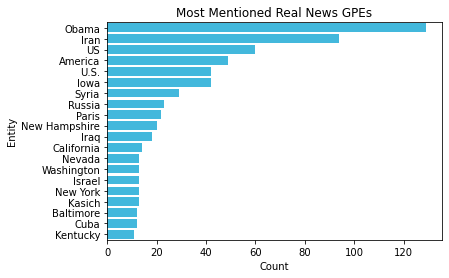

In [75]:
plot_top_ents(real_ent_df)

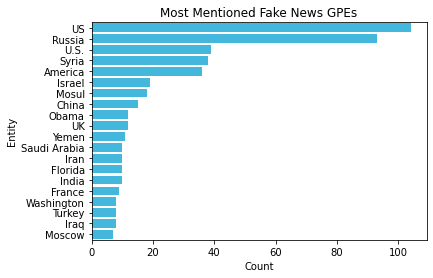

In [76]:
plot_top_ents(fake_ent_df, group_type="Fake")

### Allowing to choose sentiment function
Lets see if we can do that 

In [7]:
type(nlp)

spacy.lang.en.English

In [5]:
nlp.has_pipe("spacytextblob")

True

In [16]:
%%ipytest
def test_initialize_textblob():
    new_nlp = spacy.load("en_core_web_sm")
    sentiment_function = initialise_textblob(new_nlp)
    assert new_nlp.has_pipe("spacytextblob")
    assert callable(sentiment_function)

def initialise_textblob(spacy_model: spacy.lang) -> Callable[[Doc], float]:
    spacy_model.add_pipe("spacytextblob")
    return textblob_sentiment

.                                                                                            [100%]
1 passed in 1.04s


In [21]:
%%ipytest
import functools
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def test_initialise_vader():
    sentiment_function = initialise_vader()
    doc = nlp("I am angry")
    assert callable(sentiment_function)
    assert type(sentiment_function(doc)) is float

def vader_sentiment(doc: Doc, analyzer: SentimentIntensityAnalyzer) -> float:
    return analyzer.polarity_scores(doc.text)["compound"]
    
def initialise_vader() -> Callable[[Doc], float]:
    analyzer = SentimentIntensityAnalyzer()
    return functools.partial(vader_sentiment, analyzer=analyzer)
    

.                                                                                            [100%]
1 passed in 0.04s


In [17]:
Doc("I am angry")

TypeError: Argument 'vocab' has incorrect type (expected spacy.vocab.Vocab, got str)